This requires installing an experimental branch of `thejoker`: 

    pip install git+https://github.com/adrn/thejoker@sb2

In [1]:
import os

from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from twobody import KeplerOrbit, TwoBodyKeplerElements
import pymc as pm
from astropy.visualization.units import quantity_support

import thejoker as tj

plt.style.use('lijiaonature')

In [2]:
import astropy
import numpy
print(astropy.__version__)
print(numpy.__version__)

5.3.4
1.26.4


Generate fake data. This implementation requires that you can assign RV measurements to each binary star component:

In [3]:
n_data1 = 5
n_data2 = 3

rnd = np.random.RandomState(42)
t0 = Time('J2000') + rnd.uniform(0., 20) * u.day

truth1 = dict()
truth1['P'] = rnd.uniform(40, 80) * u.day
truth1['M0'] = rnd.uniform(0., 2*np.pi) * u.radian
truth1['omega'] = rnd.uniform(0., 2*np.pi) * u.radian
truth1['e'] = 0.2
truth1['K'] = rnd.uniform(5, 15) * u.km/u.s
truth1['v0'] = rnd.uniform(-10, 10) * u.km/u.s

elem = TwoBodyKeplerElements(P=truth1['P'], e=truth1['e'], omega=truth1['omega'],
                             M0=truth1['M0'], t0=t0, m1=1*u.Msun, m2=0.4*u.Msun,
                             i=90*u.deg, Omega=51*u.deg)  # these don't matter

In [4]:
truth1['P'] 

<Quantity 78.02857226 d>

Pack the fake data into a dictionary (required with the current API):

In [5]:
orbit1 = KeplerOrbit(elem.primary)
orbit2 = KeplerOrbit(elem.secondary)

t1 = t0 + truth1['P'] * np.sort(rnd.uniform(0, 5, n_data1))
t2 = t0 + truth1['P'] * np.sort(rnd.uniform(0, 5, n_data2))

datas = {}
for name, t, orbit in zip(['1', '2'], [t1, t2], [orbit1, orbit2]):
    rv = orbit.radial_velocity(t) + truth1['v0']
    err = np.full_like(rv.value, 5.) * u.km/u.s
    data = tj.RVData(t, rv, rv_err=err, t_ref=t0)
    datas[name] = data
    
datas

{'1': <RVData: 5 epochs>, '2': <RVData: 3 epochs>}

Plot the fake data:

<Axes: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

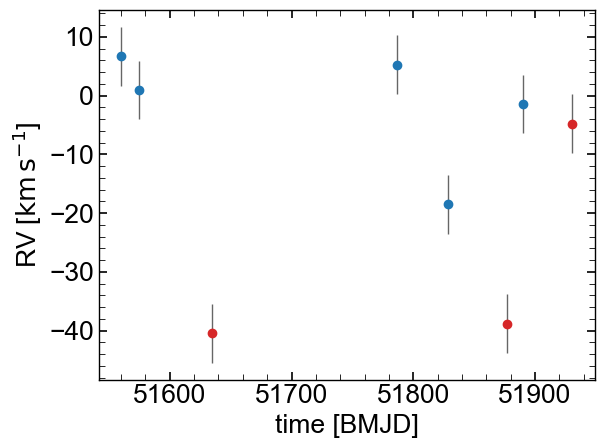

In [6]:
datas['1'].plot(color='tab:blue')  # primary
datas['2'].plot(color='tab:red')  # secondary

In [7]:
orbit1.radial_velocity(t1)

<Quantity [ 13.58418361,   7.82277723,  12.12807842, -11.65619384,
             5.45488247] km / s>

In [8]:
pwd

'/Users/lijiao/Documents/thejoker/docs/examples'

In [9]:
import thejoker.units as xu
with pm.Model() as model:
    dv0_1 = xu.with_unit(pm.Normal("dv0_1", 0, 10), u.km / u.s)
    prior = tj.JokerSB2Prior.default(
        P_min=0.5*u.day, P_max=500*u.day,
        sigma_v=25*u.km/u.s,
        sigma_K0_1=30*u.km/u.s,
        sigma_K0_2=30*u.km/u.s,
    )

In [10]:
joker = tj.TheJokerSB2(prior)

In [11]:
prior_samples,_ = prior.sample(size=1_000_00)

In [12]:
tj.TheJokerSB2?

Init signature: tj.TheJokerSB2(prior, pool=None, rng=None, tempfile_path=None)
Docstring:     
A custom Monte-Carlo sampler for two-body systems.

Parameters
----------
prior : `~thejoker.JokerPrior`
    The specification of the prior probability distribution over all
    parameters used in The Joker.
pool : `schwimmbad.BasePool` (optional)
    A processing pool (default is a `schwimmbad.SerialPool` instance).
rng : `numpy.random.Generator` (optional)
    A `numpy.random.Generator` instance for controlling random number
    generation.
tempfile_path : str (optional)
    A location on disk where The Joker may store some temporary files. Any
    files written here by The Joker should be cleaned up: If any files in
    this path persist, something must have gone wrong within The Joker.
    Default: ``~/.thejoker``
File:           /opt/anaconda3/lib/python3.11/site-packages/thejoker/thejoker_sb2.py
Type:           type
Subclasses:     

In [13]:
data = datas.copy()

In [14]:
#joker_helper = joker._make_joker_helper(datas)  # also validates data
from thejoker.likelihood_helpers import rejection_sample_inmem                                                                              
from thejoker.multiproc_helpers import rejection_sample_helper
from thejoker.data_helpers import validate_prepare_data
from thejoker.thejoker_sb2 import validate_prepare_data_sb2

all_data, ids, M = validate_prepare_data_sb2(          
    data, joker.prior.poly_trend, t_ref=data['1'].t_ref)

In [15]:
M.shape[0]

8

In [16]:
from thejoker.thejoker_sb2 import CJokerSB2Helper
joker_helper = CJokerSB2Helper(all_data, joker.prior, M) 

In [17]:
name = 'v0'
dist = prior.model[name]
pars = dist.owner.inputs[3:]
pars

[TensorConstant(TensorType(float32, shape=()), data=array(0., ... e=float32)),
 TensorConstant(TensorType(float64, shape=()), data=array(25.))]

In [18]:
_unit = getattr(prior.model[name], xu.UNIT_ATTR_NAME)
to_unit = joker_helper.internal_units[name]
_unit, to_unit

(Unit("km / s"), Unit("km / s"))

In [19]:
joker_helper.prior._sb2

True

In [20]:


joker_helper = CJokerSB2Helper(all_data, thejoker.prior, M) 
#if isinstance(prior_samples, int):
#    # If an integer, generate that many prior samples first
#    N = prior_samples
#    prior_samples = self.prior.sample(size=N, return_logprobs=return_logprobs)
#if in_memory:
#    if isinstance(prior_samples, JokerSamples):
#        ln_prior = None
#        if return_logprobs:
#            ln_prior = prior_samples["ln_prior"]
#        prior_samples, _ = prior_samples.pack(
#            units=joker_helper.internal_units, names=joker_helper.packed_order
#        )
#    else:
#        ln_prior = return_logprobs
#    samples = rejection_sample_inmem(
#        joker_helper,
#        prior_samples,
#        rng=self.rng,
#        ln_prior=ln_prior,
#        max_posterior_samples=max_posterior_samples,
#        n_linear_samples=n_linear_samples,
#        return_all_logprobs=return_all_logprobs,
#    )
#else:
#    samples = rejection_sample_helper(
#        joker_helper,
#        prior_samples,
#        pool=self.pool,
#        rng=self.rng,
#        n_prior_samples=n_prior_samples,
#        max_posterior_samples=max_posterior_samples,
#        n_linear_samples=n_linear_samples,
#        return_logprobs=return_logprobs,
#        n_batches=n_batches,
#        randomize_prior_order=randomize_prior_order,
#        return_all_logprobs=return_all_logprobs,
#    )

NameError: name 'thejoker' is not defined

In [ ]:
joker.rejection_sample?

In [21]:
samples = joker.rejection_sample(datas, prior_samples, max_posterior_samples=1000)
samples

<JokerSB2Samples [P, e, omega, M0, s, K1, K2, v0] (50 samples)>

In [22]:
from thejoker.prior_helpers import get_linear_equiv_units

In [23]:
prior_samples

<JokerSamples [P, e, omega, M0, s] (100000 samples)>

In [24]:
np.median(samples['P']), truth1['P'], np.percentile(samples['P'], [16, 50, 84]), np.std(samples['P'])

(<Quantity 78.20646325 d>,
 <Quantity 78.02857226 d>,
 <Quantity [12.63290708, 78.20646325, 80.25915956] d>,
 <Quantity 34.47639195 d>)

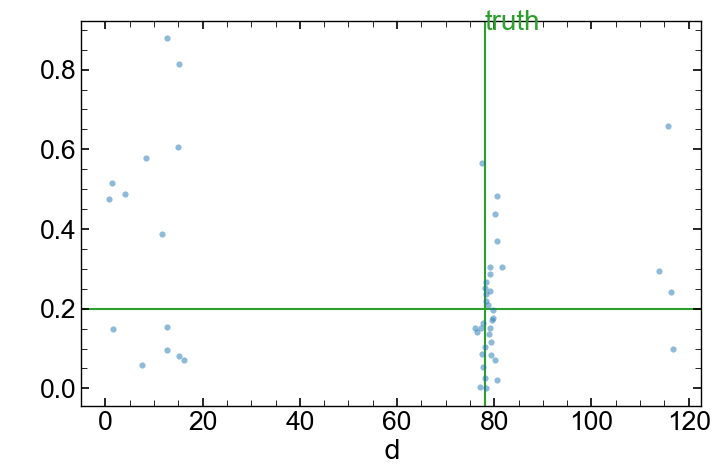

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.scatter(samples["P"], samples["e"], s=20, lw=0, alpha=0.5)

    ax.axvline(truth1["P"], zorder=-1, color="tab:green")
    ax.axhline(truth1["e"], zorder=-1, color="tab:green")
    ax.text(
        truth1["P"], 0.95, "truth", fontsize=20, va="top", ha="left", color="tab:green"
    )

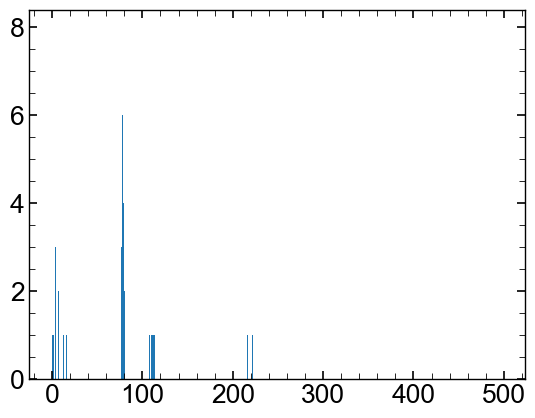

In [44]:
%matplotlib inline
_ = plt.hist(samples['P'].value, bins=np.arange(0, 500, 1))

AttributeError: 'JokerSamples' object has no attribute 'primary'

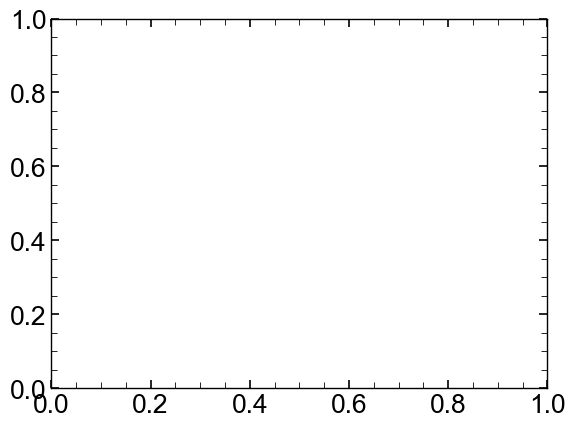

In [29]:
tgrid = np.linspace(t0.mjd, t0.mjd + 5*truth1['P'].value, 4096)

fig, ax = plt.subplots()
_ = tj.plot_rv_curves(data=datas['1'], samples=samples.primary,
                      data_plot_kwargs=dict(color='tab:blue'),
                      plot_kwargs=dict(color='tab:blue'),
                      t_grid=tgrid, ax=ax)
ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
ax.set_ylim(-75, 75)


fig, ax = plt.subplots()
_ = tj.plot_rv_curves(data=datas['2'], samples=samples.secondary, 
                      data_plot_kwargs=dict(color='tab:red'),
                      plot_kwargs=dict(color='tab:red'),
                      t_grid=tgrid, ax=ax)

ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
ax.set_ylim(-75, 75)

In [76]:
prior_samples

<JokerSamples [P, e, omega, M0, s] (100000 samples)>

### Custom prior:

In [14]:
from thejoker.prior import default_nonlinear_prior
from thejoker.prior_sb2 import default_linear_prior_sb2
import exoplanet.units as xu

In [16]:
v0, ev0 = (1., 0.5)
p, ep = (5., 0.1)

with pm.Model() as model:
    v = xu.with_unit(pm.Normal('v0',v0, ev0), u.km/u.s)
    P = xu.with_unit(pm.Normal('P', p, ep), u.day)
    e = xu.with_unit(pm.Normal('e', 0, 0.01),u.one)
    default_nonlinear_prior(pars={'P': P,'e':e})
    default_linear_prior_sb2(sigma_K0_1=30*u.km/u.s,
                             P0_1=1*u.day,
                             sigma_K0_2=30*u.km/u.s,
                             P0_2=1*u.day,
                             pars={'v0': v})